### XGBoost

<div class="alert alert-block alert-info">
    XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.
</div>

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

np.random.seed(0)

from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'

In [2]:
# Generate a synthetic dataset
X, y = make_classification(
    n_samples=50000, n_features=15, n_classes=2, n_informative=5, random_state=42
)

X, y = pd.DataFrame(X), pd.DataFrame(y)

X.columns = [f"feature_{i+1}" for i in range(len(X.columns))]

ix_train, ix_test = train_test_split(X.index, stratify=y, random_state=62)

In [3]:
# Create an XGBoost model with random forests
model_gbdt = xgb.XGBClassifier(
    booster="gbtree",
    n_estimators=1000,  # trees
    max_depth=10,
    subsample=0.5,
    gamma=0.5,
    reg_alpha=20,
    reg_lambda=20,
    min_child_weight=10,
    colsample_bynode=0.8,
    num_parallel_tree=2,  # trees per forest
    eval_metric="logloss",  # evaluation metric
    early_stopping_rounds=10,
    grow_policy="lossguide",
    random_state=42,
)

evalset = [(X.loc[ix_train], y.loc[ix_train]), (X.loc[ix_test], y.loc[ix_test])]

# Fit the model to the generated dataset
model_gbdt.fit(X.loc[ix_train], y.loc[ix_train], eval_set=evalset)

# Make predictions using the model
predictions_trn = model_gbdt.predict_proba(X.loc[ix_train])[:, 1]
predictions_tst = model_gbdt.predict_proba(X.loc[ix_test])[:, 1]

gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1

print(f"Train Gini score: {gini_trn:.2%}\n" f"Test Gini score: {gini_tst:.2%}")

[0]	validation_0-logloss:0.54626	validation_1-logloss:0.54642
[1]	validation_0-logloss:0.45594	validation_1-logloss:0.45765
[2]	validation_0-logloss:0.39858	validation_1-logloss:0.40107
[3]	validation_0-logloss:0.35277	validation_1-logloss:0.35585
[4]	validation_0-logloss:0.31624	validation_1-logloss:0.32011
[5]	validation_0-logloss:0.29152	validation_1-logloss:0.29628
[6]	validation_0-logloss:0.26528	validation_1-logloss:0.27063
[7]	validation_0-logloss:0.24296	validation_1-logloss:0.24831
[8]	validation_0-logloss:0.22727	validation_1-logloss:0.23330
[9]	validation_0-logloss:0.21415	validation_1-logloss:0.22061
[10]	validation_0-logloss:0.20207	validation_1-logloss:0.20886
[11]	validation_0-logloss:0.19335	validation_1-logloss:0.20034
[12]	validation_0-logloss:0.18805	validation_1-logloss:0.19538
[13]	validation_0-logloss:0.18084	validation_1-logloss:0.18858
[14]	validation_0-logloss:0.17538	validation_1-logloss:0.18351
[15]	validation_0-logloss:0.17257	validation_1-logloss:0.18117
[1

In [4]:
# check how many trees are trained
booster_ = model_gbdt.get_booster()
num_trees = booster_.best_iteration + 1
print(f"Total number of trees in the final model: {num_trees}")

# get a dump
booster_dump = booster_.get_dump()
num_trees_dump = len(booster_dump)
print(f"Total number of trees used in estimation: {num_trees_dump}")

Total number of trees in the final model: 161
Total number of trees used in estimation: 342


In [5]:
# get margins (log odds, leaf weights)
booster_.trees_to_dataframe()[booster_.trees_to_dataframe().Feature.isin(["Leaf"])][
    "Gain"
][:10]

9    -0.225236
10    0.190313
20   -0.143501
21   -0.134992
27   -0.000000
29   -0.222734
31    0.010724
32   -0.110243
33    0.161738
34   -0.000000
Name: Gain, dtype: float64

<h4> Loss Curve </h4>

[PythonGuides.com: Matplotlib Update Plot in Loop](https://pythonguides.com/matplotlib-update-plot-in-loop/)

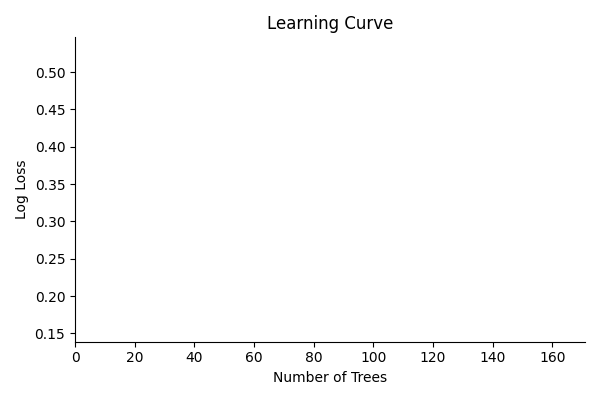

In [6]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib widget

# Import the loss curve
results = model_gbdt.evals_result()
loss_values = results["validation_1"]["logloss"]

# Create figure and subplot
fig, ax = plt.subplots(figsize=(6, 4))
x_plot = []
y_plot = []

# Plot
# (plot_1,) = ax.plot(x, y)
(plot_1,) = ax.plot(x_plot, y_plot, color="#a7fe01", label="Log Loss")
plt.axis([0, len(loss_values), min(loss_values), max(loss_values)])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Log Loss")
plt.title("Learning Curve")
plt.tight_layout()

# Animation Function


def animate_plot(i):
    x_plot = np.arange(i)
    y_plot = loss_values[:i]
    plot_1.set_data(x_plot, y_plot)
    return (plot_1,)


# Animated Function
ani = FuncAnimation(fig, animate_plot, frames=len(loss_values), interval=100)

# Save as gif
# path_to_export = "/Users/deburky/Documents/python/risk-practitioner-ebook/risk-practitioner/images"
# ani.save(f"{path_to_export}/learning_curve.gif", writer="pillow", fps=10, dpi=600)
# ani.save(f"learning_curve.gif", writer="pillow", fps=10, dpi=600)